<a href="https://colab.research.google.com/github/Ana1890/MRIimages_deeplearning/blob/main/Hibrido_nb4_earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadificación de Alzheimer por medio de imágenes MRI utilizando redes neuronales

Dataset provisto por el sitio web de Kaggle: https://www.kaggle.com/tourist55/Alzheimers-dataset-4-class-of-images

El mismo está compuesto por imágenes MRI en formato .jpg y tienen cuatro clases tanto en sus datos de test como de train. Estas clases son:

* 1) Mild demented
* 2) Moderate demented
* 3) Non demented
* 4) Very mild demented

Para los datos de test tenemos:

* 179 imágenes Mild demented
* 12  imágenes Moderate demented
* 640 imágenes Non demented
* 448 imágenes very mild demented

Para los datos de train: 
* 717  imágenes Mild demented
* 52   imágened Moderate demented
* 2560 imágenes Non demented
* 1792 imágenes Very mild demented

Se intentará elevar el accuracy de un modelo de red neuronal residual evitando overfitting y probando de cambiar distintos parámetros tales como el número de épocas


In [1]:
!pip install progress

  Created wheel for progress: filename=progress-1.5-cp37-none-any.whl size=8088 sha256=a61607f9eb9c287113d5213d1bc1ab0cd53dfc276ae0ecf65b286469f6650ac8
  Stored in directory: /root/.cache/pip/wheels/6c/c8/80/32a294e3041f006c661838c05a411c7b7ffc60ff939d14e116
Successfully built progress


Accedemos a nuestro drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset')

In [4]:
!ls

loss_plot.png  test  train


In [5]:
!ls test

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [6]:
!ls train

MildDemented  ModerateDemented	NonDemented  VeryMildDemented


In [7]:
!pip install pytorchtools

# Importando librerías necesarias

In [8]:
# Generales
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

# Data
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset

# Model
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
# from pytorchtools import EarlyStopping

# Métricas y visualización
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

# Cargar datos

In [9]:
FOLDER_PATH = '/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset/train'
categories = sorted(os.listdir(FOLDER_PATH))
num_classes = 4

MILD_INDEX = categories.index("MildDemented")
MODERATE_INDEX = categories.index("ModerateDemented")
NON_INDEX = categories.index("NonDemented")
VERYMILD_INDEX = categories.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path = [list() for category in categories]

for index, category in enumerate(categories):
    category_path = os.path.join(FOLDER_PATH, category)

    # Recorrer imágenes
    images = [i for i in os.listdir(category_path)]
    for image_name in images:
        image_path = os.path.join(category_path, image_name)
        images_path[index].append(image_path)

print("Sobre el dataset")
for category_name, images in zip(categories, images_path):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 717
#Imagenes de la clase ModerateDemented: 52
#Imagenes de la clase NonDemented: 2560
#Imagenes de la clase VeryMildDemented: 1792


In [10]:
train_data = list()

for class_index, images_per_class in enumerate(images_path):
  train_data.extend([(img, class_index) for img in images_per_class])

train_data1 = np.array(train_data)

In [11]:
train_data1[:,1]

array(['0', '0', '0', ..., '3', '3', '3'], dtype='<U128')

In [12]:
# Generamos datos de validación

train_data1, val_data, train_labels1, val_labels = train_test_split(train_data1[:,0], train_data1[:,1].astype(int) , test_size=0.20, random_state=42)

print(train_data1.shape,  val_data.shape, train_labels1.shape, val_labels.shape)

(4096,) (1025,) (4096,) (1025,)


In [13]:
train_data2 = list()
train_data2.extend([(path, label) for path,label in zip(train_data1, train_labels1)])

In [14]:
val_data2 = list()
val_data2.extend([(path, label) for path,label in zip(val_data, val_labels)])

In [15]:
FOLDER_PATH_TEST = '/content/drive/MyDrive/Programa de investigación en IB/Imágenes/Alzheimer_s Dataset/test'
categories_test = sorted(os.listdir(FOLDER_PATH_TEST))
num_classes = 4

MILD_INDEX_TEST = categories_test.index("MildDemented")
MODERATE_INDEX_TEST = categories_test.index("ModerateDemented")
NON_INDEX_TEST = categories_test.index("NonDemented")
VERYMILD_INDEX_TEST = categories_test.index("VeryMildDemented")

# Almacenar las rutas a las imagenes agrupados por categorias en memoria
images_path_test = [list() for category in categories_test]

for index, category in enumerate(categories_test):
    category_path_test = os.path.join(FOLDER_PATH_TEST, category)

    # Recorrer imágenes
    images_test = [i for i in os.listdir(category_path_test)]
    for image_name in images_test:
        image_path_test = os.path.join(category_path_test, image_name)
        images_path_test[index].append(image_path_test)

print("Sobre el dataset")
for category_name, images in zip(categories_test, images_path_test):
    print("#Imagenes de la clase {}: {}".format(category_name, len(images)))

Sobre el dataset
#Imagenes de la clase MildDemented: 179
#Imagenes de la clase ModerateDemented: 12
#Imagenes de la clase NonDemented: 640
#Imagenes de la clase VeryMildDemented: 448


In [16]:
test_data = list()

for class_index, images_per_class in enumerate(images_path_test):
  test_data.extend([(img, class_index) for img in images_per_class])

* Las clases están muy desbalanceadas

## Visualización random

In [17]:
random.seed(0)

def pick_randomly_file(image_list, ammount):
    max_length = len(image_list)
    chosen_images = []
    for _ in range(ammount):
        index = random.randint(0, max_length)
        chosen_images.append(image_list[index])
    
    return chosen_images


sample_images = 5
mild_sample = pick_randomly_file(images_path[MILD_INDEX], sample_images)
moderate_sample = pick_randomly_file(images_path[MODERATE_INDEX], sample_images)
non_sample = pick_randomly_file(images_path[NON_INDEX], sample_images)
Verymild_sample = pick_randomly_file(images_path[VERYMILD_INDEX], sample_images)


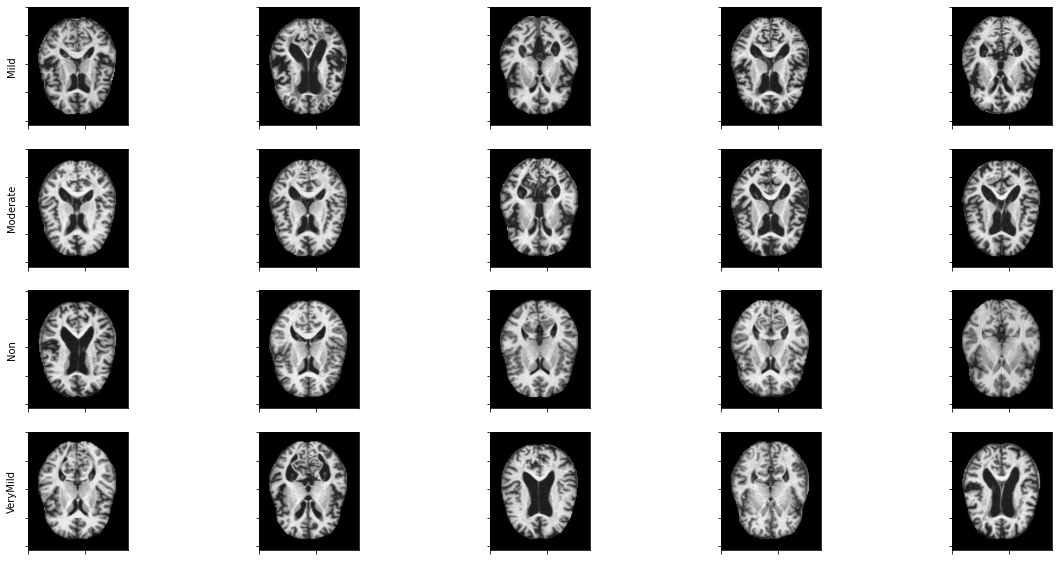

In [18]:
def visualize_sample(image_list, ax, title):
    ax[0].set_ylabel(title)
    for index in range(len(image_list)):        
        ax[index].imshow(cv2.imread(image_list[index]))
        ax[index].set_yticklabels([])
        ax[index].set_xticklabels([])


fx, ax = plt.subplots(num_classes,sample_images, figsize=(20,10))
visualize_sample(mild_sample, ax[0], "Mild")
visualize_sample(moderate_sample, ax[1], "Moderate")
visualize_sample(non_sample, ax[2], "Non")
visualize_sample(Verymild_sample, ax[3], "VeryMild")

plt.show()

In [19]:
image_s = [mild_sample, moderate_sample, non_sample, Verymild_sample]

for s in image_s:
  for l in s:
    print("El tamaño de la imagen ", s.index(l), "de la clase ", categories[image_s.index(s)], "es: ", (cv2.imread(l).size), "y la dimensión es: ", (cv2.imread(l).shape))


El tamaño de la imagen  0 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  1 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  2 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  3 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  4 de la clase  MildDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  0 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  1 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  2 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  3 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)
El tamaño de la imagen  4 de la clase  ModerateDemented es:  109824 y la dimensión es:  (208, 176, 3)


El conjunto de datos se encuentra desbalanceado, tiene imágenes de una dimensión de 208 x 176 x 3 dimensiones. Se podría pasar a 1 dimensión y de ahí normalizar, o tener 3 dimensiones y normalizarla directamente.

Pre-procesamiento: 
* Data Augmentation: Mild demented, Moderate demented
* Normalzación
* Visualización
* Reshape, binarización, morfología

# Clase Dataset

In [20]:
class MRIDataset(Dataset):

    """MRI dataset."""

    def __init__(self, raw_data, input_size=(224,224)):
        self.raw_data = raw_data
        self.input_size = input_size
        self.images = list()
        self.annotations = list()
        # self.transf = transforms.RandomAutocontrast()
        self.count = 0

        for path_to_image, label in self.raw_data:
            image_tensor = self._preprocess(path_to_image)
            target_tensor = torch.tensor(label)

            self.images.append(image_tensor)
            self.annotations.append(target_tensor)

    def _preprocess(self, path_to_image):
        '''
        Función dedicada a convertir nuestra imagen en números.
        Ademas también transforma la imagen en un tensor, que es necesario
        Para poder ser usado en el modelo.
        También se cambia el tamaño de la imagen para que sea uniforme en todas 
        las imágenes.
        '''

        img = cv2.imread(path_to_image)
        img = cv2.resize(img, self.input_size)

        # Aquí podemos plantear pasar la imagen a escala de grises

        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Aquí normalizamos
        img = img / 255.

        input_tensor = torch.from_numpy(img).reshape(3, self.input_size[0], self.input_size[1]).float()
        self.count += 1
        print("transforme a tensor ", self.count)

        # input_tensor = self.transf(input_tensor)
        # print("transforme a sharpness")

        return input_tensor

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, index):
        sample = {'input': self.images[index], 'target': self.annotations[index]}
        return sample

# Creamos la red neuronal

In [21]:
model = models.resnet50(pretrained=True)

# Freezing model

# for param in model.parameters():
#   param.requires_grad = False

new_model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
    
    model.layer1,
    model.layer2,
    model.layer3,
    *(list(model.layer4.children())[:-1]),

    nn.Conv2d(2048, 32, kernel_size=(1,1), stride=(1, 1), bias=False),
    nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(32*7*7,4),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4,4),
    nn.LogSoftmax(dim=1)

    ) 


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

In [22]:
# Capa 4 sin su última sub capa
# newmodel = torch.nn.Sequential(*(list(model.layer4.children())[:-1]))
# print(newmodel)

https://www.it-swarm-es.com/es/python/como-eliminar-la-ultima-capa-fc-de-un-modelo-resnet-en-pytorch/807243870/

# Definimos algunos hiperparámetros

In [23]:
# Hyperparameters
lr = 0.0001              # Learning rate
input_size = (224,224)

# Select the device to use
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Send the model to the device
new_model = new_model.to(device)

# Create dataloader
from torch.utils.data import DataLoader

batch_size = 16

In [24]:
from torchsummary import summary

summary(new_model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [25]:
dataset = MRIDataset(train_data2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

transforme a tensor  1
transforme a tensor  2
transforme a tensor  3
transforme a tensor  4
transforme a tensor  5
transforme a tensor  6
transforme a tensor  7
transforme a tensor  8
transforme a tensor  9
transforme a tensor  10
transforme a tensor  11
transforme a tensor  12
transforme a tensor  13
transforme a tensor  14
transforme a tensor  15
transforme a tensor  16
transforme a tensor  17
transforme a tensor  18
transforme a tensor  19
transforme a tensor  20
transforme a tensor  21
transforme a tensor  22
transforme a tensor  23
transforme a tensor  24
transforme a tensor  25
transforme a tensor  26
transforme a tensor  27
transforme a tensor  28
transforme a tensor  29
transforme a tensor  30
transforme a tensor  31
transforme a tensor  32
transforme a tensor  33
transforme a tensor  34
transforme a tensor  35
transforme a tensor  36
transforme a tensor  37
transforme a tensor  38
transforme a tensor  39
transforme a tensor  40
transforme a tensor  41
transforme a tensor  42
t

In [26]:
dataset_val = MRIDataset(val_data2)
dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle=True) 

transforme a tensor  1
transforme a tensor  2
transforme a tensor  3
transforme a tensor  4
transforme a tensor  5
transforme a tensor  6
transforme a tensor  7
transforme a tensor  8
transforme a tensor  9
transforme a tensor  10
transforme a tensor  11
transforme a tensor  12
transforme a tensor  13
transforme a tensor  14
transforme a tensor  15
transforme a tensor  16
transforme a tensor  17
transforme a tensor  18
transforme a tensor  19
transforme a tensor  20
transforme a tensor  21
transforme a tensor  22
transforme a tensor  23
transforme a tensor  24
transforme a tensor  25
transforme a tensor  26
transforme a tensor  27
transforme a tensor  28
transforme a tensor  29
transforme a tensor  30
transforme a tensor  31
transforme a tensor  32
transforme a tensor  33
transforme a tensor  34
transforme a tensor  35
transforme a tensor  36
transforme a tensor  37
transforme a tensor  38
transforme a tensor  39
transforme a tensor  40
transforme a tensor  41
transforme a tensor  42
t

In [27]:
import torch.optim as optim

# Create an optimizer
optimizer = optim.Adam(new_model.parameters(), lr=lr)

# Loss Function
criterion = nn.NLLLoss()

# Entrenamiento

* Creamos la clase Early stopping para evitar el overfitting

In [28]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, trace_func=print): #path='checkpoint.pt', ):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        # self.path = path
        self.trace_func = trace_func
        self.best_model = None

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.best_model = model
        self.val_loss_min = val_loss

In [29]:
import sys
from progress.bar import Bar

def train_model(new_model, train_data, criterion, optimizer, num_epochs, patience):

    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    Bar.check_tty = False
    Bar.file = sys.stdout

    

    for epoch in range(num_epochs):

        total_loss = 0.0
        processed = 0
        bar = Bar('Training Model', max=len(dataloader))

        new_model.train()
        for index, data_dict in enumerate(dataloader):
            input_tensor = data_dict["input"]
            gt_tensor = data_dict["target"]

            input_tensor = input_tensor.to(device)
            gt_tensor = gt_tensor.to(device)

            optimizer.zero_grad()
            output = new_model(input_tensor)
            loss = criterion(output, gt_tensor)
            train_losses.append(loss.item())
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            processed += input_tensor.shape[0]
            Bar.suffix = 'Train: [{0}][{1}/{2}]|Tot: {total:} |ETA: {eta:} '.format(epoch+1, processed, len(train_data),total=bar.elapsed_td, eta=bar.eta_td)
            Bar.suffix = Bar.suffix + '| Loss {:.4f} '.format(total_loss / (index + 1))
            bar.next()
        bar.finish()


        # validate the model #
        ######################
        new_model.eval() # prep model for evaluation
        for index, data_dict in enumerate(dataloader_val):

            val_tensor = data_dict["input"]
            gtv_tensor = data_dict["target"]

            val_tensor = val_tensor.to(device)
            gtv_tensor = gtv_tensor.to(device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = new_model(val_tensor)
            # calculate the loss
            loss = criterion(output, gtv_tensor)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_valid_losses.append(valid_loss)
        avg_train_losses.append(train_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                 f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, new_model)
        
        if early_stopping.early_stop:
          print("Early stopping")
          break
        
    # load the last checkpoint with the best model
    # new_model.load_state_dict(torch.load('checkpoint.pt'))

    return  new_model, avg_train_losses, avg_valid_losses, early_stopping.best_model

    # return new_model

In [30]:
# patience = 20
model,train_loss, val_loss, best_model = train_model(new_model, train_data2, criterion, optimizer, num_epochs = 25, patience = 20)

Training Model |################################| Train: [1][4096/4096]|Tot: 0:00:41 |ETA: 0:00:01 | Loss 1.2824 
[ 0/25] valid_loss: 1.25517
Validation loss decreased (inf --> 1.255172).  Saving model ...
Training Model |################################| Train: [2][4096/4096]|Tot: 0:00:41 |ETA: 0:00:01 | Loss 1.2424 
[ 1/25] valid_loss: 1.19327
Validation loss decreased (1.255172 --> 1.193267).  Saving model ...
Training Model |################################| Train: [3][4096/4096]|Tot: 0:00:41 |ETA: 0:00:01 | Loss 1.1697 
[ 2/25] valid_loss: 1.03490
Validation loss decreased (1.193267 --> 1.034899).  Saving model ...
Training Model |################################| Train: [4][4096/4096]|Tot: 0:00:41 |ETA: 0:00:01 | Loss 1.0457 
[ 3/25] valid_loss: 0.91386
Validation loss decreased (1.034899 --> 0.913855).  Saving model ...
Training Model |################################| Train: [5][4096/4096]|Tot: 0:00:41 |ETA: 0:00:01 | Loss 0.8969 
[ 4/25] valid_loss: 0.80975
Validation loss dec

Habría que probar de agregar un Early stopping para controlar el overfitting

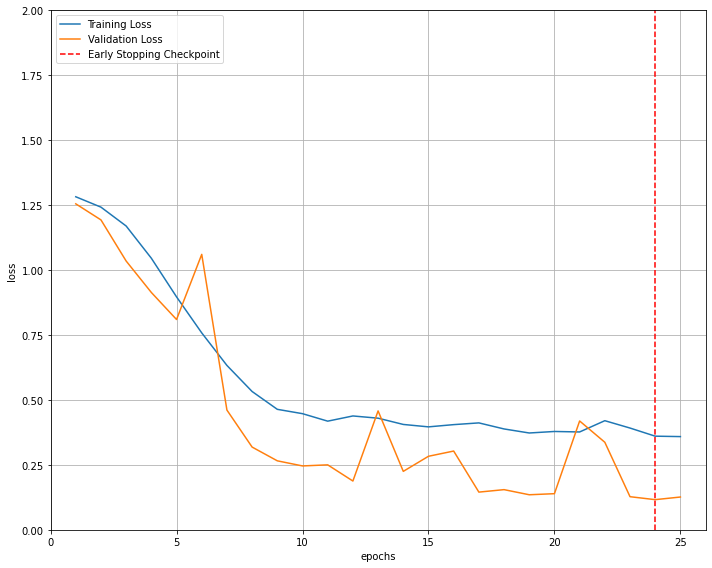

In [31]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = val_loss.index(min(val_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 2) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Pre procesamos datos nuevos

In [32]:
# transfor = transforms.RandomAutocontrast()

def preprocess(path_to_image, label):
    img = cv2.imread(path_to_image)
    img = cv2.resize(img, input_size)    
    img = img / 255.
    input_tensor = torch.from_numpy(img).reshape(1, 3, input_size[0],input_size[1]).float()
    # input_tensor = transfor(input_tensor)
    gt_tensor = torch.tensor([label])
    return input_tensor, gt_tensor

In [33]:
y_true = []
y_pred = []

def test_model(new_model, test_data):
    new_model = new_model.eval()
    Bar.check_tty = False
    Bar.file = sys.stdout
    bar = Bar('Testing Model', max=len(test_data))

    stats = [0 for _ in categories]
    total_items = [0 for _ in categories]
    for index, input_data in enumerate(test_data):
        img_path, target_class = input_data

        input_tensor, _ = preprocess(img_path, target_class)
        input_tensor = input_tensor.to(device)
        output = new_model(input_tensor)
        prediction = torch.argmax(output).item()

        y_pred.append(prediction)
        y_true.append(target_class)

        if target_class == prediction:
            stats[target_class] += 1
        total_items[target_class] += 1
        Bar.suffix = 'Test: [{0}/{1}]|Tot: {total:} |ETA: {eta:} '.format(index, len(test_data),total=bar.elapsed_td, eta=bar.eta_td)
        bar.next()
    
    bar.finish()
    for category_name, stat, tot in zip(categories, stats, total_items):
        acc = stat * 1.0 / tot
        print("Accuracy for class {}: {:.4f}".format(category_name, acc))

    print("\nReporte de clasificación: \n", classification_report(y_true, y_pred, target_names= categories))
    print("\nMatriz de confusión: \n")

    conf_arr = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=categories, yticklabels=categories)

    plt.title('Alzheimer\'s Disease Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.show(ax)

    print("\n Balanced accuracy score: ", balanced_accuracy_score(y_true, y_pred))
    print("\n F1 score for unbalanced classes: ", f1_score(y_true, y_pred, average='macro'), "\n")

# Probamos el modelo con datos nuevos

Testing Model |################################| Test: [5120/5121]|Tot: 0:01:04 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.9749
Accuracy for class ModerateDemented: 0.0000
Accuracy for class NonDemented: 0.9957
Accuracy for class VeryMildDemented: 0.9983

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       1.00      0.97      0.99       717
ModerateDemented       0.00      0.00      0.00        52
     NonDemented       0.98      1.00      0.99      2560
VeryMildDemented       0.99      1.00      0.99      1792

        accuracy                           0.98      5121
       macro avg       0.74      0.74      0.74      5121
    weighted avg       0.97      0.98      0.98      5121


Matriz de confusión: 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


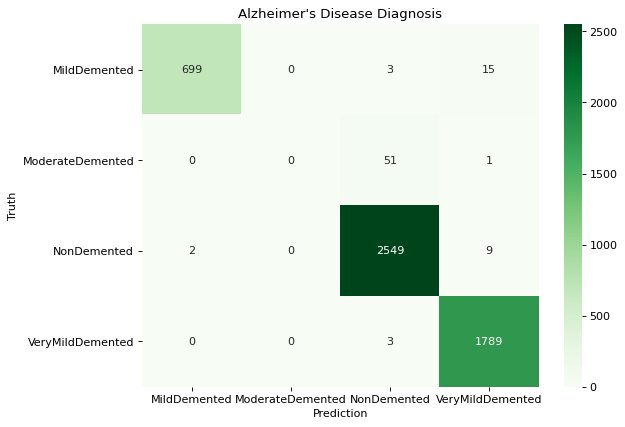


 Balanced accuracy score:  0.7422311038366707

 F1 score for unbalanced classes:  0.741241950622005 

Testing Model |################################| Test: [1278/1279]|Tot: 0:05:42 |ETA: 0:00:01 
Accuracy for class MildDemented: 0.1117
Accuracy for class ModerateDemented: 0.0000
Accuracy for class NonDemented: 0.7500
Accuracy for class VeryMildDemented: 0.6629

Reporte de clasificación: 
                   precision    recall  f1-score   support

    MildDemented       1.00      0.80      0.89       896
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.92      0.95      0.93      3200
VeryMildDemented       0.88      0.93      0.90      2240

        accuracy                           0.91      6400
       macro avg       0.70      0.67      0.68      6400
    weighted avg       0.91      0.91      0.91      6400


Matriz de confusión: 



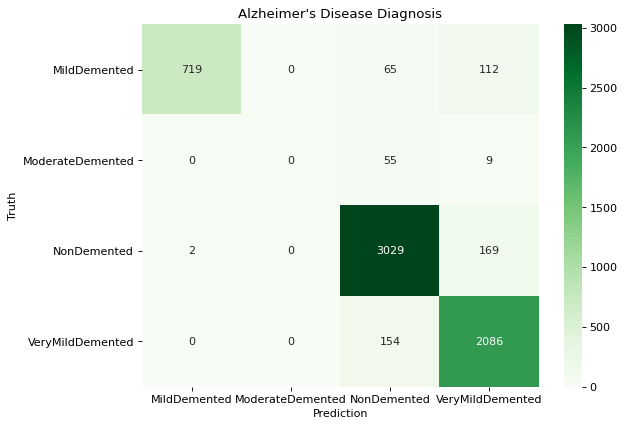


 Balanced accuracy score:  0.6700669642857142

 F1 score for unbalanced classes:  0.6811710111417338 



In [34]:
test_model(best_model, train_data)
test_model(best_model, test_data)

# Aumentación de datos

https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/ 

https://medium.com/analytics-vidhya/image-data-augmentation-to-balance-dataset-in-classification-tasks-5e25bbd9a228